## Setup

We begin by loading the *poems* package and setting our output directory.

In [1]:
setwd('C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania/poems')
library(poems)
library(raster)
library(gridExtra)
library(ggplot2)
library(BayesFactor)
OUTPUT_DIR='C:/Users/tm/Downloads/utas/thesis/chapter1/tasmania/poems'

# function to round to any arbitrary value
round_any <- function(x, accuracy, f = round) {
  f(x/ accuracy) * accuracy
}

### read data

In [2]:
#this is the land area of tasmania
baselayer=read.csv('baselayer.csv')
baselayer=subset(baselayer, grid == 0)
landarea=c(as.numeric(row.names(baselayer)))

In [3]:
#1985-1995
# Cunningham et al., 2021
population_size=c(#34475,
 35924,
 38256,
 41029,
 43487,
 44622,
 46387,
 48845,
 50105,
 51618,
 52437,
 53067)

In [4]:
#this is the validation area of spotlight survey data from nva
valid_spotlight=read.csv('valid_spotlight.csv')

# Subset valid dataframe based on landarea
valid_spotlight=subset(valid_spotlight, index %in% landarea)

#reindex based on landarea
identity_spotlight=match(valid_spotlight$index,landarea)

In [5]:
#this is the validation area of camera trap
valid_camera=read.csv('valid_camera.csv')

# Subset valid dataframe based on landarea
valid_camera=subset(valid_camera, index %in% landarea)

#reindex based on landarea
identity_camera=match(valid_camera$index,landarea)

In [6]:
#this is the validation area of R drive
valid_monitor=read.csv('valid_monitor.csv')

# Subset valid dataframe based on landarea
valid_monitor=subset(valid_monitor, index %in% landarea)

#reindex based on landarea
identity_monitor=match(valid_monitor$index,landarea)

In [7]:
#habitat suitability map
#estimated via vegetation,altitude and seabird colony
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Tasman/habitat%20suitability%20tasman.ipynb
suitability=read.csv('suitability.csv')


floornum=0.1
suitability$pred=(suitability$pred-min(suitability$pred))/(max(suitability$pred)-min(suitability$pred))*(1-floornum)+floornum

### known variables

In [8]:
#dispersal portion and avg distance
known_dispersal_p = 0.1945
known_dispersal_b =5.821

In [9]:
#baseline matrix is estimated via mark recapture data 
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Tasman/baseline%20matrix%2tasman.ipynb
leslie_matrix=c(0.        , 0.489, 1.4539, 1.947, 1.5079,0.547 ,
                1, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.976 , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.899, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.84, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.791,
       0.791      )
agegroup=c("y0","y1","y2","y3","y4","y5")

In [10]:
#how many grid cells
gridlen=35

#coordinates extreme value
lonmin=144.165967
latmin=-43.833736
lonmax=148.576978
latmax=-40.349895

In [11]:
#model start year
baseyear=1985

#years of simulation
simulation_years=40

#simulation timeframe per round
simulation_intervals=1

#number of simulations
num_of_sims=5000

#max density 2 per sq km, in female model divided by two
maxden=100

#initial abundance
initial_population=34475

#validation threshold for camera and spotlight
correlation_threshold=0.9

#area name
areaname='Tasmania'

## Workflow

The *poems* workflow, which implements a pattern-oriented modeling (POM) approach 
(Grimm et al., 2005), is achieved via a framework of interoperable components:


The workflow is summarized by the following six steps:

1. Build the population model for the study region.
1. Build generators for dynamically generating model parameters.
1. Sample model and generator parameters for each simulation.
1. Build a simulation manager to run each simulation.
1. Build a results manager to generate summary results (metrics).
1. Build a validator to select a model ensemble.

### Step 1: Build the population model for the study region
Create a model template using the *PopulationModel* class. If the model is spatially
explicit, then define the study region via the *Region* class. All fixed model inputs,
such as environmental correlations, as well as any user-defined functions for processes
such as harvesting, should be set at this stage.

We could create these components in any order and set model parameters separately, but 
let's setup our study region, generate environmental correlations, and define a harvest
function prior to initializing the template model with all the fixed parameters.

##### Study region
First, we'll define our study region tasman with some longitude-latitude
coordinates.

In [12]:
(lonmax-lonmin)/gridlen
(latmax-latmin)/gridlen

[1] 0.1260289

[1] 0.09953831

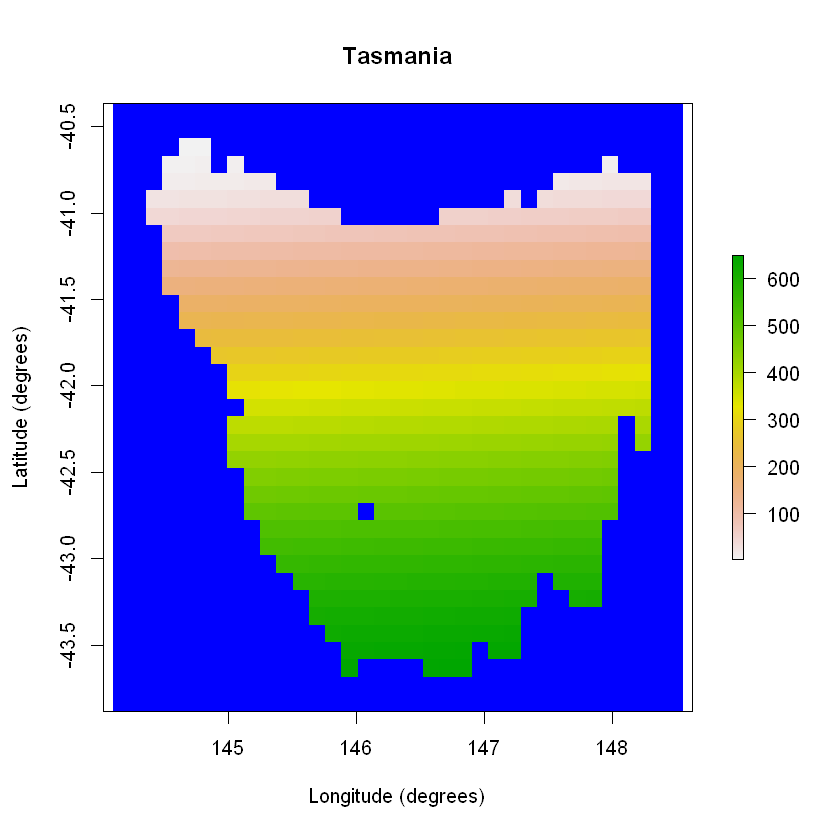

In [13]:
#build the raster of channel
coordinates <- data.frame(x = rep(seq(lonmin, lonmax, 0.127028885714286), gridlen),
                          y = rep(seq(latmin, latmax, 0.1005383142857144),each= gridlen))
template_raster <- Region$new(coordinates = coordinates)$region_raster # full extent
template_raster[][-landarea] <- NA 

region <- Region$new(template_raster = template_raster)

raster::plot(region$region_raster, main = areaname,
             xlab = "Longitude (degrees)", ylab = "Latitude (degrees)",
             colNA = "blue",)

##### Environmental correlation
Next, we'll define a distance-based spatial correlation for applying environmental 
stochasticity within our model. The generated correlation data is compacted for 
computational efficiency (with large-scale models).

In [14]:
# Distance-based environmental correlation (via a compacted Cholesky decomposition)
env_corr <- SpatialCorrelation$new(region = region, amplitude = 0.4, breadth = 500)
correlation <- env_corr$get_compact_decomposition(decimals = 2)

##### Template model
Finally, we can build our template model with these and other fixed parameters.

[0. , 0.489, 1.4539, 1.947, 1.5079,0.547]

[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]

[0.0, 0.976, 0.0, 0.0, 0.0, 0.0]

[0.0, 0.0, 0.899, 0.0, 0.0, 0.0]

[0.0, 0.0, 0.0, 0.84, 0.0, 0.0]

[0.0, 0.0, 0.0, 0.0, 0.791, 0.0]

In [15]:
# siska=c(0. , 0.13, 1.3, 1.65,1.21,0,

# 0.81, 0.0, 0.0, 0.0, 0.0, 0.0,

# 0.0, 0.81, 0.0, 0.0, 0.0, 0.0,

# 0.0, 0.0, 0.84, 0.0, 0.0, 0.0,

# 0.0, 0.0, 0.0, 0.85, 0.0, 0.0,

# 0.0, 0.0, 0.0, 0.0, 0.67, 0.0)

# durrant=c(0. , 0.42, 1.42, 1.12, 0,0,

# 0.989, 0.0, 0.0, 0.0, 0.0, 0.0,

# 0.0, 0.996, 0.0, 0.0, 0.0, 0.0,

# 0.0, 0.0, 0.994, 0.0, 0.0, 0.0,

# 0.0, 0.0, 0.0, 0.995, 0.0, 0.0,

# 0.0, 0.0, 0.0, 0.0, 0.988, 0.0)

# eigen_result <- eigen(matrix(durrant,nrow=6,ncol=6))

# # Step 3: Identify the dominant eigenvalue (largest absolute value)
# max(abs(eigen_result$values))

In [16]:
# Build a stage matrix generator based on density dependant growth
stage_matrix_gen <- Generator$new(
  description = "stage matrix",
  region_indices=region$region_indices,
  base_matrix = matrix(leslie_matrix, nrow = length(agegroup), ncol = length(agegroup), byrow = TRUE,
                       dimnames = list(agegroup,agegroup )),
  inputs = c("growth_rate_max","initial_n", "density_max"),
  outputs = c("stage_matrix"),
  generative_requirements = list(stage_matrix = "function"))
stage_matrix_gen$add_function_template(
  "stage_matrix",
  function_def = function (params) {
    return(params$base_matrix*(1-params$initial_n/(params$density_max*length(params$region_indices))))
  },
  call_params = c("base_matrix", "growth_rate_max","initial_n", "density_max","region_indices"))

### Step 2: Build generators for dynamically generating model parameters
Some model parameters are single values, whilst others are represented as arrays and
other multi-value data structures. Usually, we don't wish to sample each individual 
value within these multi-value parameters (in step 3), but to generate them dynamically
via one or more intermediate sampled parameters. Here we build generators for model 
initial abundance, carrying capacity, and dispersal.

##### Habitat suitability
Firstly, our initial abundance and carrying capacity generator utilizes an example
(mock) habitat suitability for our defined study region. 

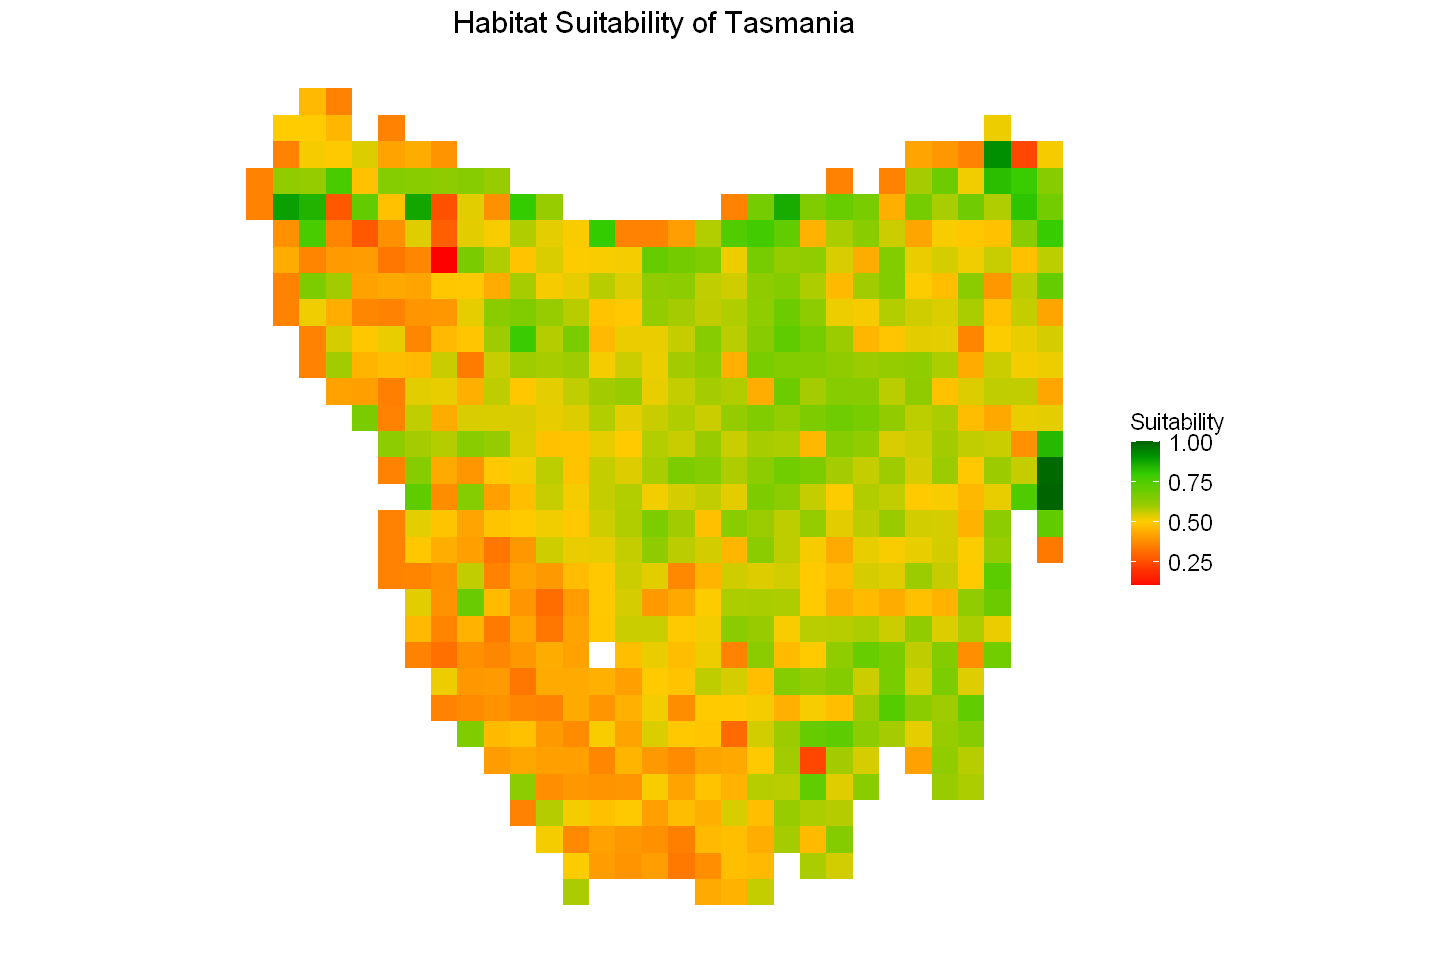

In [103]:
# Example habitat suitability data
example_hs <- suitability$pred
example_hs_raster <- region$region_raster

# Assign habitat suitability values to the raster
example_hs_raster[region$region_indices] <- example_hs

# Convert raster to points (coordinates and values) for ggplot2
raster_df <- as.data.frame(rasterToPoints(example_hs_raster))
colnames(raster_df) <- c("Longitude", "Latitude", "Suitability")

# Create ggplot with color gradient using scale_fill_gradientn
ggplot(raster_df, aes(x = Longitude, y = Latitude, fill = Suitability)) +
  geom_raster() +
  scale_fill_gradientn(colors = c("#FF0000", "#FF3300", "#FF6600", "#FF9900", "#FFCC00", 
             "#99CC00", "#66CC00", "#33CC00", "#009900", "#006400"),
                        limits = c(min(example_hs), max(example_hs)),name='Suitability')  +
  labs(
    title = "Habitat Suitability of Tasmania",
  ) +
  theme_minimal() +
  theme(aspect.ratio = 1,  # Force a 1:1 aspect ratio
        axis.text = element_blank(),  # Remove axis labels
        axis.ticks = element_blank(),  # Remove axis ticks
        panel.grid.major = element_blank(),  # Remove major gridlines
        panel.grid.minor = element_blank(),  # Remove minor gridlines
        axis.title.x = element_blank(),  # Remove x-axis label
        axis.title.y = element_blank(),  # Remove y-axis label
        legend.text = element_text(size = 14),  # Make the legend text larger
        legend.title = element_text(size = 14),  # Make the legend title larger
        plot.title = element_text(size = 18, hjust = 0.5)
  )+coord_fixed(ratio = 1)  # Ensure the plot has a square aspect ratio

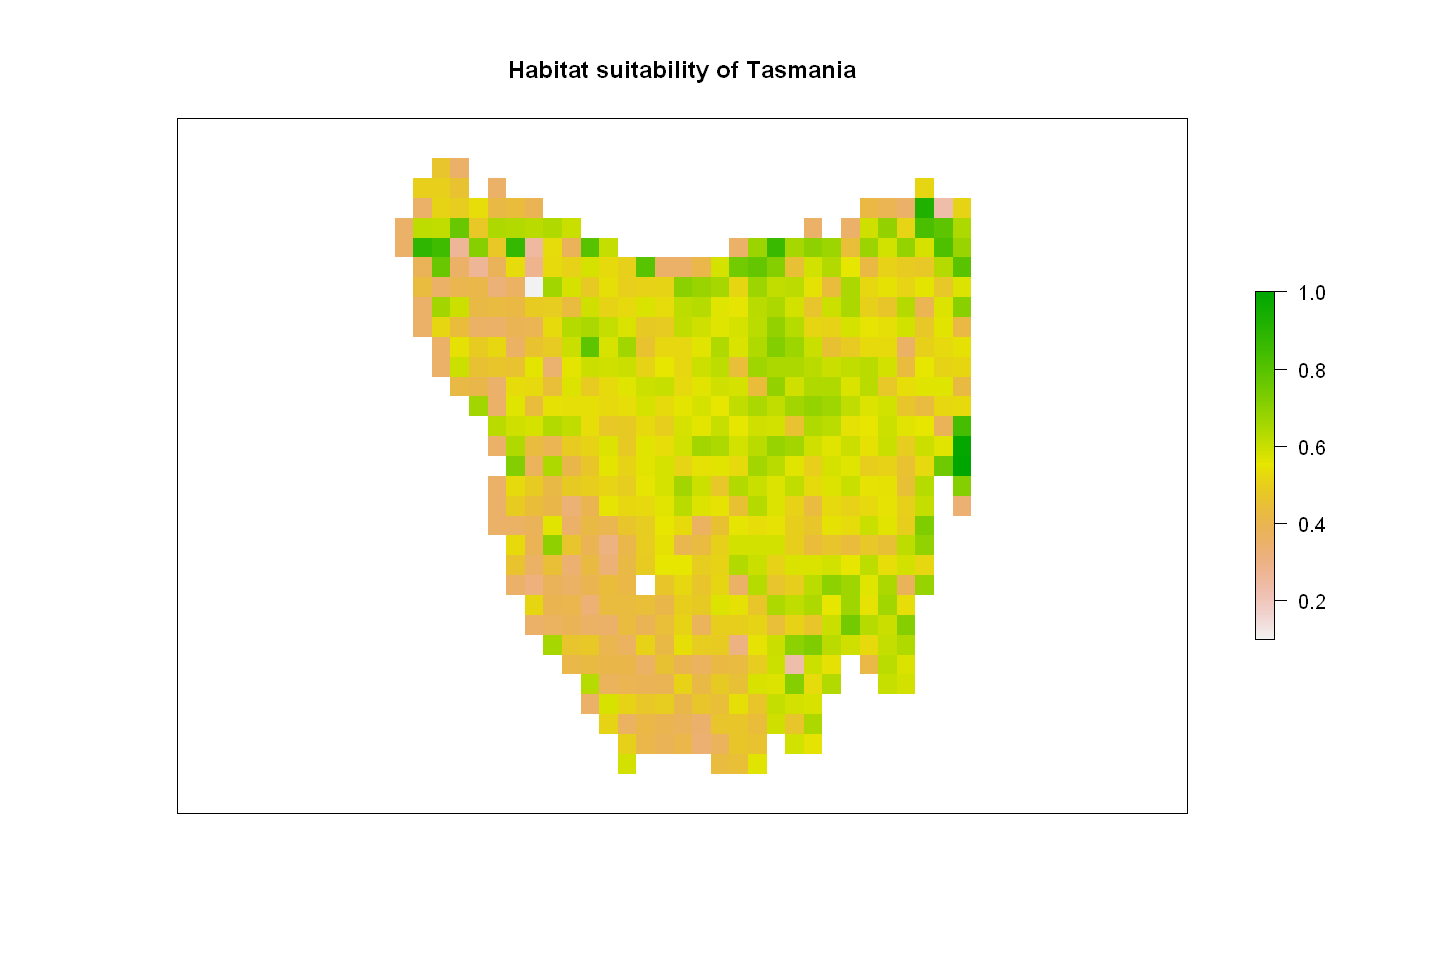

In [89]:
# Example habitat suitability
example_hs=suitability$pred
example_hs_raster <- region$region_raster
example_hs_raster[region$region_indices] <- example_hs
raster::plot(example_hs_raster, main = "Habitat suitability of Tasmania",
#              xlab = "Longitude (degrees)", ylab = "Latitude (degrees)",
             colNA = "white", axes = FALSE)

##### Initial abundance and carrying capacity generator
The generator utilizes generic template functionality for user-defined custom
functions. It uses sampled input parameters (initial total abundance and maximum cell
density), along with habitat suitability, to generate the desired output model 
parameters (initial abundance and carrying capacity) via these user-defined functions. 
Generators can also be configured to read values from files or generate values via 
probabilistic distributions. 

In [18]:
# Initial abundance and carrying capacity generated via example habitat suitability
capacity_gen <- Generator$new(description = "Capacity generator",
                              example_hs = example_hs, # template attached
                              inputs = c("initial_n", "density_max"),
                              outputs = c("initial_abundance", "carrying_capacity"))
capacity_gen$add_generative_requirements(list(initial_abundance = "function",
                                              carrying_capacity = "function"))
capacity_gen$add_function_template("initial_abundance",
                                   function_def = function(params) {
#                                        stats::rmultinom(1, size = params$initial_n,
#                                                       prob = params$example_hs)[,1]
                                       
                                       round(params$initial_n/sum(params$example_hs)*params$example_hs)
                                   },
                                   call_params = c("initial_n", "example_hs"))
capacity_gen$add_function_template("carrying_capacity",
                                   function_def = function(params) {
                                     round(params$density_max*params$example_hs)
                                   },
                                   call_params = c("density_max", "example_hs"))

In [19]:
dispersal_friction <- DispersalFriction$new(
   region = region,
   conductance = example_hs
 )

In [20]:
# Distance-based dispersal generator
# https://github.com/je-suis-tm/Devil-Project/blob/main/Chapter1/Tasmania/dispersal%20estimate%20tasmania.ipynb
dispersal_gen <- DispersalGenerator$new(region = region,
                                        dispersal_max_distance = 400, # in km 
                                        distance_scale = 1000,
                                        dispersal_friction =  dispersal_friction,
                                        inputs = c("dispersal_p", "dispersal_b"),
                                        decimals = 5)
dispersal_gen$calculate_distance_data() # pre-calculate
# test_dispersal <- dispersal_gen$generate(input_values = list(dispersal_p = known_dispersal_p, 
#                                                              dispersal_b = known_dispersal_b))
#head(test_dispersal$dispersal_data[[1]])

##### Density Dependence

In [21]:
# Define neighborhoods based on a 12 km home range from each 
# grid cell for density dependence calculations (using a dispersal generator)
distance_data <- dispersal_gen$distance_data[[1]]
nh_data <- distance_data[which(distance_data$distance_class <= 19), 2:1]

neighborhoods <- as.list(1:length(landarea))
for (i in 1:nrow(nh_data)) {
  neighborhoods[[nh_data$source_pop[i]]] <- c(neighborhoods[[nh_data$source_pop[i]]],
                                               nh_data$target_pop[i])
}
#neighborhoods[1:3] # examine

In [22]:
# User-defined function for Ricker logistic density dependence via neighborhoods
density_dependence <- list(
  neighborhoods = neighborhoods,
  function (params) {
    
    # Apply logistic density dependence using neighborhoods
    growth_rate_max <- params$growth_rate_max
    nh_density_abundance <- unlist(lapply(params$neighborhoods,
                                          function (nh_indices) {
                                            sum(params$density_abundance[nh_indices])
                                          }))
    nh_carrying_capacity <- unlist(lapply(params$neighborhoods,
                                          function (nh_indices) {
                                            sum(params$carrying_capacity[nh_indices])
                                          }))
    occupied_indices <- params$occupied_indices
    growth_rate <- (1 - (nh_density_abundance[occupied_indices]/
                                           nh_carrying_capacity[occupied_indices]))
    params$transition_array[, , occupied_indices] <-
      params$apply_multipliers(params$transition_array[, , occupied_indices],
                               params$calculate_multipliers(growth_rate))
    
    
    # Remove fecundities for single thylacines
    single_indices <- which(nh_density_abundance == 1)
    params$transition_array[, , single_indices] <-
      (params$transition_array[, , single_indices]*as.vector(+(!params$fecundity_mask)))
    
    return(params$transition_array)
  }
)

In [23]:
#stage_matrix # examine
model_template <- PopulationModel$new(region = region,
                                      time_steps = simulation_years, # years
                                      years_per_step = simulation_intervals,
                                      populations = region$region_cells, 
                                      stages = length(agegroup),
                                      stage_matrix = stage_matrix_gen$stage_matrix,
                                      #demographic_stochasticity = TRUE,
                                      #standard_deviation = 0.01,
                                      correlation = correlation,
                                      density_dependence = "logistic",
                                      results_selection = c("abundance"),
                                      simulation_order = c( "transition", "dispersal","results"))

### Step 3: Sample model and generator parameters for each simulation
In order to explore the model parameter space to find the best models, we generate
Latin hypercube samples of model and generator parameters to be simulated, using the
*LatinHypercubeSampler* class. This class has functionality for generating sample
parameters via Uniform, Normal, Lognormal, Beta, and Triangular distributions.

In [23]:
# Generate sampled values for variable model parameters via LHS
lhs_gen <- LatinHypercubeSampler$new()

#set as wide as possible
lhs_gen$set_uniform_parameter("growth_rate_max", lower = 0.1, upper = 0.7, decimals = 2)

#automatically fetched
lhs_gen$set_uniform_parameter("density_max", lower = as.integer(maxden*0.4), 
                              upper = as.integer(maxden*2.5), decimals = 2)
lhs_gen$set_uniform_parameter("initial_n", lower = 10000,
                              upper = 20000,
                              decimals = 0)
lhs_gen$set_uniform_parameter("dispersal_b", lower = 1,
                              upper = 50, decimals = 0)
lhs_gen$set_uniform_parameter("dispersal_p", lower = 0.1, upper = 0.7, decimals = 2)
sample_data <- lhs_gen$generate_samples(number = num_of_sims)

#remove max capacity smaller than initial population
sample_data=sample_data[sample_data$density_max*length(landarea)>=sample_data$initial_n,]
num_of_sims=length(row.names(sample_data))

#save as pickle
save(sample_data, file="sample data.Rda")

### Step 4: Build a simulation manager to run each simulation
We now wish to run a simulation for each set (or row) of sampled parameters. The
*SimulationManager* class manages the generation of parameters (via the generators),
the running the model simulations, and writing simulation results to disk. It also
maintains a log of each simulation's success and any errors or warnings encountered.

In [24]:
# Create a simulation manager and run the sampled model simulations
sim_manager <- SimulationManager$new(sample_data = sample_data,
                                     model_template = model_template,
                                     generators = list(capacity_gen, stage_matrix_gen, dispersal_gen),
                                     parallel_cores = 6,
                                     results_dir = OUTPUT_DIR)
run_output <- sim_manager$run(results_dir = tempdir())
run_output$summary
#dir(OUTPUT_DIR, "*.RData") # includes result files 
#dir(OUTPUT_DIR, "*.txt") # plus simulation log

[1] "5000 of 5000 sample models ran and saved results successfully"

In [25]:
#get time id and space id
valid_monitor$yearid=valid_monitor$year-baseyear
valid_monitor$reindex=identity_monitor

# Create a list to store the functions
summary_functions <- list()

# Programmatically define the functions and add them to the list
for (i in 1:length(rownames(valid_monitor))) {
    #results refer to actual output rdata file from simulation manager
  summary_functions[[paste0("p", i)]] <- function(results,sid,tid,idx) {
    results$abundance[results$sid[results$idx],results$tid[results$idx]]
  }
}

#add correlation of non parametric ranking
for (i in 1:simulation_years) {
    #results refer to actual output rdata file from simulation manager
  summary_functions[[paste0("rho_spotlight", i)]] <- function(results,identity_spotlight,rank_act_spotlight,
                                                             sim_yrs) {
    rank_est <- rank(results$abundance[identity_spotlight,sim_yrs])
    cor(rank_est,rank_act_spotlight)
  }
}

for (i in 1:simulation_years) {
    #results refer to actual output rdata file from simulation manager
  summary_functions[[paste0("rho_camera", i)]] <- function(results,identity_camera,rank_act_camera,
                                                             sim_yrs) {
    rank_est <- rank(results$abundance[identity_camera,sim_yrs])
    cor(rank_est,rank_act_camera)
  }
}


for (i in 1:length(population_size)) {
    #results refer to actual output rdata file from simulation manager
  summary_functions[[paste0("total", i)]] <- function(results,pop_size) {
    results$all$abundance[pop_size]
  }
}

# Add the additional required function to the list
summary_functions[["n"]] <- "abundance"

In [26]:
# Create the ResultsManager object with summary_functions assigned
results_manager <-ResultsManager$new(
  simulation_manager = sim_manager,
  simulation_results = PopulationResults$new(),
  summary_metrics = paste0("p", 1:length(rownames(valid_monitor))),
  summary_matrices = c("n"),
  tid=valid_monitor$yearid,
  sid=valid_monitor$reindex,
  idx=1:length(rownames(valid_monitor)),
  sim_yrs=1:simulation_years,
  pop_size=1:length(population_size),
  rank_act_spotlight=order(order(valid_spotlight$dftd)),
  rank_act_camera=order(order(valid_camera$rel_abun)),
  summary_functions=summary_functions,  # Assign summary_functions here
  parallel_cores = 6
)

gen_output <- results_manager$generate()
gen_output$summary
#dir(OUTPUT_DIR, "*.txt") # plus generation log
# results_manager$summary_metric_data
# results_manager$summary_matrix_list

[1] "0 of 5000 summary metrics/matrices generated from sample results successfully"

In [34]:
#monitor sites
tid=valid_monitor$yearid
sid=valid_monitor$reindex
raw_mat=results_manager$summary_matrix_list$n

#find validation target in abundance matrix
valid_target <- matrix(ncol = length(rownames(valid_monitor)), nrow = num_of_sims)  
for (i in 1:length(rownames(valid_monitor))) {
  valid_target[,i] <- raw_mat[,(tid[i]-1)*length(landarea)+sid[i]]}
results_manager$summary_metric_data[paste0("p", 1:length(rownames(valid_monitor)))]=valid_target

In [137]:
#calculate correlation for camera validation target
rank_act=order(order(valid_camera$rel_abun))
    
rho_camera <- numeric(0)
for (i in 1:num_of_sims){
    first_row <- raw_mat[i, ]
    reshaped=t(matrix(first_row,ncol = simulation_years,
                    nrow = length(landarea)))
    reshaped[is.na(reshaped)] <- 0 
    for (j in 1:simulation_years) {
    rank_est=order(order(reshaped[j,identity_camera]))    
    rho_camera <- c(rho_camera, cor(rank_act,rank_est))
        }
}

results_manager$summary_metric_data[paste0("rho_camera", 1:simulation_years)]=t(matrix(rho_camera,nrow = simulation_years,
                    ncol = num_of_sims))

In [138]:
#calculate correlation for spotlight validation target
rank_act=order(order(valid_spotlight$dftd))
    
rho_spotlight <- numeric(0)
for (i in 1:num_of_sims){
    first_row <- raw_mat[i, ]
    reshaped=t(matrix(first_row,ncol = simulation_years,
                    nrow = length(landarea)))
    reshaped[is.na(reshaped)] <- 0 
    for (j in 1:simulation_years) {
    rank_est=order(order(reshaped[j,identity_spotlight]))    
    rho_spotlight <- c(rho_spotlight, cor(rank_act,rank_est))
        }
}

results_manager$summary_metric_data[paste0("rho_spotlight", 1:simulation_years)]=t(matrix(rho_spotlight,nrow = simulation_years,
                    ncol = num_of_sims))

In [45]:
#calculate total abundance
pop_est=numeric(0)
for (i in 1:num_of_sims)
{
for (j in 1:length(population_size)){
    first_row <- raw_mat[i, ]
    reshaped=t(matrix(first_row,ncol = simulation_years,
                    nrow = length(landarea)))
    reshaped[is.na(reshaped)] <- 0 
    pop_est <- c(pop_est, sum(reshaped[j,]))
}
    }
results_manager$summary_metric_data[paste0("total", 1:length(population_size))]=t(matrix(pop_est,nrow = length(population_size),
                    ncol = num_of_sims))

In [139]:
#save as pickle
save(results_manager, file="models.Rda")

### Step 6: Build a validator to select a model ensemble
We now select and analyze our 'best' models via a *Validator* class object, which by
default utilizes an approximate Bayesian computation (ABC) approach (Beaumont, Zhang, 
& Balding, 2002) provided by the *abc* library (Csillery et al., 2015). The validator
can be configured appropriately for a problem domain (see the *abc* documentation). 
Here we use the default configuration to select the best 3 models, along with a weight
value, which is indicative of the congruence between each model's summary metrics and 
the corresponding target patterns. Also provided (with the default settings) is a 
diagnostic output (PDF) file, containing statistical information for analyzing the 
contribution of model parameters in the selection/validation process (see the *abc* 
documentation). For our simple demonstration the metrics and corresponding targets are 
relatively trivial, having the aim of producing stable population abundances with high 
harvest. However, the package facilitates the use more complex spatio-temporal metrics 
and targets (demonstrated in more advanced vignettes).

In [24]:
#load pickle files so no need to retrain
load("models.Rda")
load("sample data.Rda")


raw_mat=results_manager$summary_matrix_list$n

In [25]:
#showna
validation_var=results_manager$summary_metric_data
length(row.names(validation_var[!complete.cases(validation_var),]))/length(row.names(validation_var))

[1] 0

In [26]:

validation_var=validation_var[complete.cases(validation_var),]
sample_data=sample_data[validation_var$index,]
selected_mat=raw_mat[validation_var$index,]
selected_mat[is.na(selected_mat)] <- 0 
row.names(sample_data) <- NULL
row.names(validation_var) <- NULL
validation_var$index=1:length(row.names(validation_var))

In [27]:
# #fill na with zero for those who got non na correlation
# na_index <- which(!is.na(validation_var$rho_spotlight))
# subset <- validation_var[na_index, ]
# subset[is.na(subset)]=0
# validation_var=rbind(validation_var[is.na(validation_var$rho_spotlight),],subset)

# #list of na
# remove_index=which(!complete.cases(validation_var))

# # Create a validator for selecting the 'best' example models
# if (length(remove_index)!=0)    {
#  sample_data = sample_data[-remove_index,]
#  validation_var=validation_var[-remove_index,]
#  row.names(sample_data) <- NULL
#  row.names(validation_var) <- NULL
# }

In [28]:
#get population est
obs_targets=valid_monitor$population
names(obs_targets)=paste0("p", 1:length(rownames(valid_monitor)))

#female model
obs_targets=as.integer(obs_targets/2)

#add non parametric targets
for (i in 1:simulation_years){
    obs_targets<-c(obs_targets,correlation_threshold)
    obs_targets<-c(obs_targets,correlation_threshold)}

#female model
pop_act=as.integer(population_size[1:length(population_size)]/2)

#add total abundance
obs_targets<-c(obs_targets,pop_act)

In [29]:

validator <- Validator$new(simulation_parameters = sample_data,
                           simulation_summary_metrics =validation_var[-1],
                           observed_metric_targets = obs_targets,
                           output_dir = OUTPUT_DIR)

In [30]:
validator$run(tolerance = 0.02, output_diagnostics = TRUE)

12345678910
12345678910


Warning message:
"Validation function generated warning: All parameters are "none" transformed."


## viz

In [31]:
#rescale weights as they dont sum up to one
weights=validator$selected_simulations 
weights$weight=weights$weight/sum(weights$weight)

In [32]:
#get posterior weighted avg, min and max
selected_data=sample_data[weights$index,]

posterior_max=sapply(selected_data, function(x) max(x, na.rm = TRUE))
posterior_min=sapply(selected_data, function(x) min(x, na.rm = TRUE))
posterior_p80=sapply(selected_data, function(x) quantile(x, probs = 0.80, na.rm = TRUE))                    
posterior_p20=sapply(selected_data, function(x) quantile(x, probs = 0.20, na.rm = TRUE))
posterior_mean=colSums(sample_data[weights$index,]*replicate(length(sample_data), weights$weight))

#get prior avg, min and max
prior_max=sapply(results_manager$sample_data, function(x) max(x, na.rm = TRUE))
prior_min=sapply(results_manager$sample_data, function(x) min(x, na.rm = TRUE))
prior_p80=sapply(results_manager$sample_data, function(x) quantile(x, probs = 0.80, na.rm = TRUE))
prior_p20=sapply(results_manager$sample_data, function(x) quantile(x, probs = 0.20, na.rm = TRUE))
prior_mean=sapply(results_manager$sample_data, function(x) mean(x, na.rm = TRUE))

#create dataframe into a designated format
prior <- data.frame(  
    prior = paste(prior_mean, 
                   "(", prior_p20, "-",prior_p80, ")") )

posterior <- data.frame( posterior = paste(posterior_mean, 
                   "(", posterior_p20, "-",posterior_p80, ")") )

#add index column
params_distrib=cbind(prior,posterior)
row.names(params_distrib)=names(prior_mean)

In [33]:
#add %change from prior to posterior
params_distrib$change=posterior_mean/prior_mean-1

In [34]:
#test stats for distribution diff between prior and posterior
pval=c()
for (col_name in colnames(sample_data))
{
    # Perform the t-test using BayesFactor
    bf_result <- ttestBF(x = sample_data[col_name][[1]], y = selected_data[col_name][[1]])

    # Extract the Bayes Factor value
    bf_value <- extractBF(bf_result)

    pval=c(pval,bf_value$bf)
}

params_distrib$bayes=pval

# #test stats for distribution diff between prior and posterior
# pval=c()
# for (col_name in colnames(sample_data))
# {
#     ks_test=ks.test(sample_data[col_name][[1]],selected_data[col_name][[1]])
#     pval=c(pval,ks_test$p.value)
# }

Warning message:
"package 'BayesFactor' was built under R version 4.4.2"
Loading required package: coda

Warning message:
"package 'coda' was built under R version 4.4.2"
Loading required package: Matrix

************
Welcome to BayesFactor 0.9.12-4.7. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************



### posterior

In [35]:
paste(length(rownames(selected_data)),"out of",num_of_sims)

[1] "100 out of 5000"

In [128]:
for (i in c('Maximum Growth Rate',
'Maximum Carry Capacity per Cell (10 km x 10 km)',
'Initial Abundance (Females)',
'Average Dispersal Distance (km)',
'Proportion of Non-dispersal'))
    {print(i)}

[1] "Maximum Growth Rate"
[1] "Maximum Carry Capacity per Cell (10 km x 10 km)"
[1] "Initial Abundance (Females)"
[1] "Average Dispersal Distance (km)"
[1] "Proportion of Non-dispersal"


In [36]:
row.names(params_distrib)=c('Maximum Growth Rate',
'Maximum Carry Capacity per Cell (10 km x 10 km)',
'Initial Abundance (Females)',
'Average Dispersal Distance (km)',
'Proportion of Non-dispersal')
params_distrib

,prior,posterior,change,bayes
,<chr>,<chr>,<dbl>,<dbl>
Maximum Growth Rate,0.399996 ( 0.22 - 0.58 ),0.256865768720498 ( 0.158 - 0.44 ),-0.35782916,1.910665e+06
Maximum Carry Capacity per Cell (10 km x 10 km),145.000072 ( 82.016 - 207.98 ),114.276080597047 ( 67.898 - 159.546 ),-0.21188949,5.106708e+04
Initial Abundance (Females),15000.0048 ( 12001.2 - 17998.8 ),14332.4442353903 ( 12044.8 - 18499.2 ),-0.04450402,1.118996e-01
Average Dispersal Distance (km),25.5004 ( 11 - 40 ),6.63891062781565 ( 4 - 8 ),-0.73965465,4.162648e+31
Proportion of Non-dispersal,0.400002 ( 0.22 - 0.58 ),0.37281777996844 ( 0.188 - 0.57 ),-0.06796021,2.892102e-01


In [37]:
# Example data frame with min, max, and median values
data_summary <- data.frame(category=factor(row.names(params_distrib)),
  min = 2*(posterior_p20-prior_min)/(prior_max-prior_min)-1,
  median = 2*(posterior_mean-prior_min)/(prior_max-prior_min)-1,
  max = 2*(posterior_p80-prior_min)/(prior_max-prior_min)-1
)

row.names(data_summary)=NULL

#add prior
new_row <- data.frame(
  category = factor(c("prior")),
  min = -0.6,
  median = 0,
  max = 0.6
)
data_summary=rbind(new_row,data_summary)

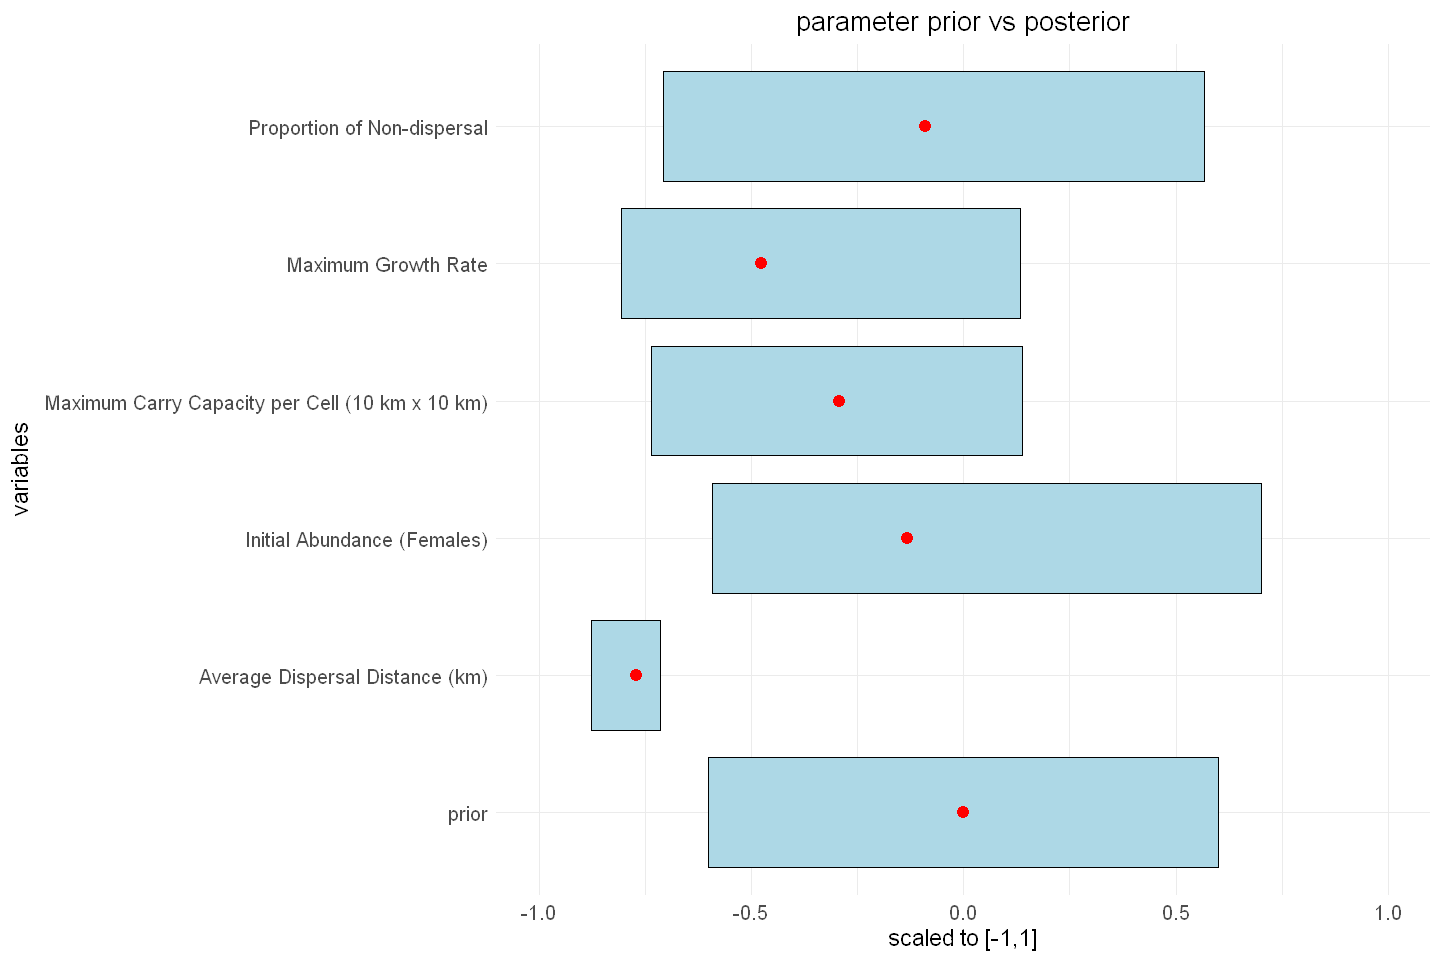

In [108]:
# Create the plot
options(repr.plot.width=12, repr.plot.height=8)
p <- ggplot(data_summary, aes(y = category)) +
  geom_rect(aes(xmin = min, xmax = max, ymin = as.numeric(category) - 0.4, ymax = as.numeric(category) + 0.4), 
            fill = "lightblue", color = "black") +  # Draw the box
  geom_point(aes(x = median), color = "red", size = 3) +  # Mark the median
  labs(x = "scaled to [-1,1]", y = "variables", title = "parameter prior vs posterior") +theme_minimal() +
  theme(
#       panel.grid.major = element_blank(),  # Remove major gridlines
#       panel.grid.minor = element_blank(),  # Remove minor gridlines
    axis.title.x = element_text(size = 14),  # X-axis label font size
    axis.title.y = element_text(size = 14),  # Y-axis label font size
    axis.text.x = element_text(size = 12),   # X-axis tick labels font size
    axis.text.y = element_text(size = 12),   # Y-axis tick labels font size
    plot.title = element_text(size = 16,hjust = 0.5),    # Plot title font size  
  )+
  xlim(- 1, 1)  # Adjust these values as needed

# Print the plot
print(p)

In [39]:
dir(OUTPUT_DIR, "*.pdf") # plus validation diagnostics (see abc library documentation)

[1] "validation_diagnostics.pdf"

In [40]:
# install.packages('rmarkdown')

# library(rmarkdown)

# setwd("C:/Users/tm/Downloads/")

# input <- "poems tasman.ipynb"

# # First convert to .Rmd...
# convert_ipynb(input)

In [39]:
#export result
selected_mat=raw_mat[weights$index,]

write.csv(data.frame(selected_mat),'./base/raw.csv')

write.csv(data.frame(weights),'./base/weights.csv')

write.csv(data.frame(landarea),'./base/land.csv')

write.csv(data.frame(selected_data),'./base/rates.csv')

### population line

In [45]:
mat_list <- matrix(NA,nrow=dim(selected_mat)[1],ncol=simulation_years)
for (year in 1:simulation_years){
    abund=rowSums(selected_mat[,((year-1)*length(landarea)+1):(year*length(landarea))])
    mat_list[,year]=abund
}
    

selected_total=data.frame(mat_list)

In [46]:
colnames(selected_total)=baseyear:(baseyear+simulation_years-1)
rownames(selected_total) <- NULL

#get posterior mean
posterior_total=colSums(selected_total*replicate(length(selected_total), weights$weight))

#normalized
posterior_total=posterior_total/posterior_total[1]
selected_total=selected_total/selected_total[,1]
selected_total=rbind(selected_total,posterior_total)

selected_total_long <- reshape(selected_total, 
                   varying = colnames(selected_total), # Exclude the 'time' column
                   v.names = "value",       # Create a new 'value' column
                   timevar = "variable",        # Create a new 'line' column
                   times = colnames(selected_total),   # Use column names (numbers) as 'line' identifiers
                   direction = "long")

#hightlight posterior mean
selected_total_long$line_color <- ifelse(selected_total_long$id == 101, "red", "grey")
selected_total_long$line_size <- ifelse(selected_total_long$id == 101, 3, 0.5)

selected_total_long$variable=as.numeric(selected_total_long$variable)

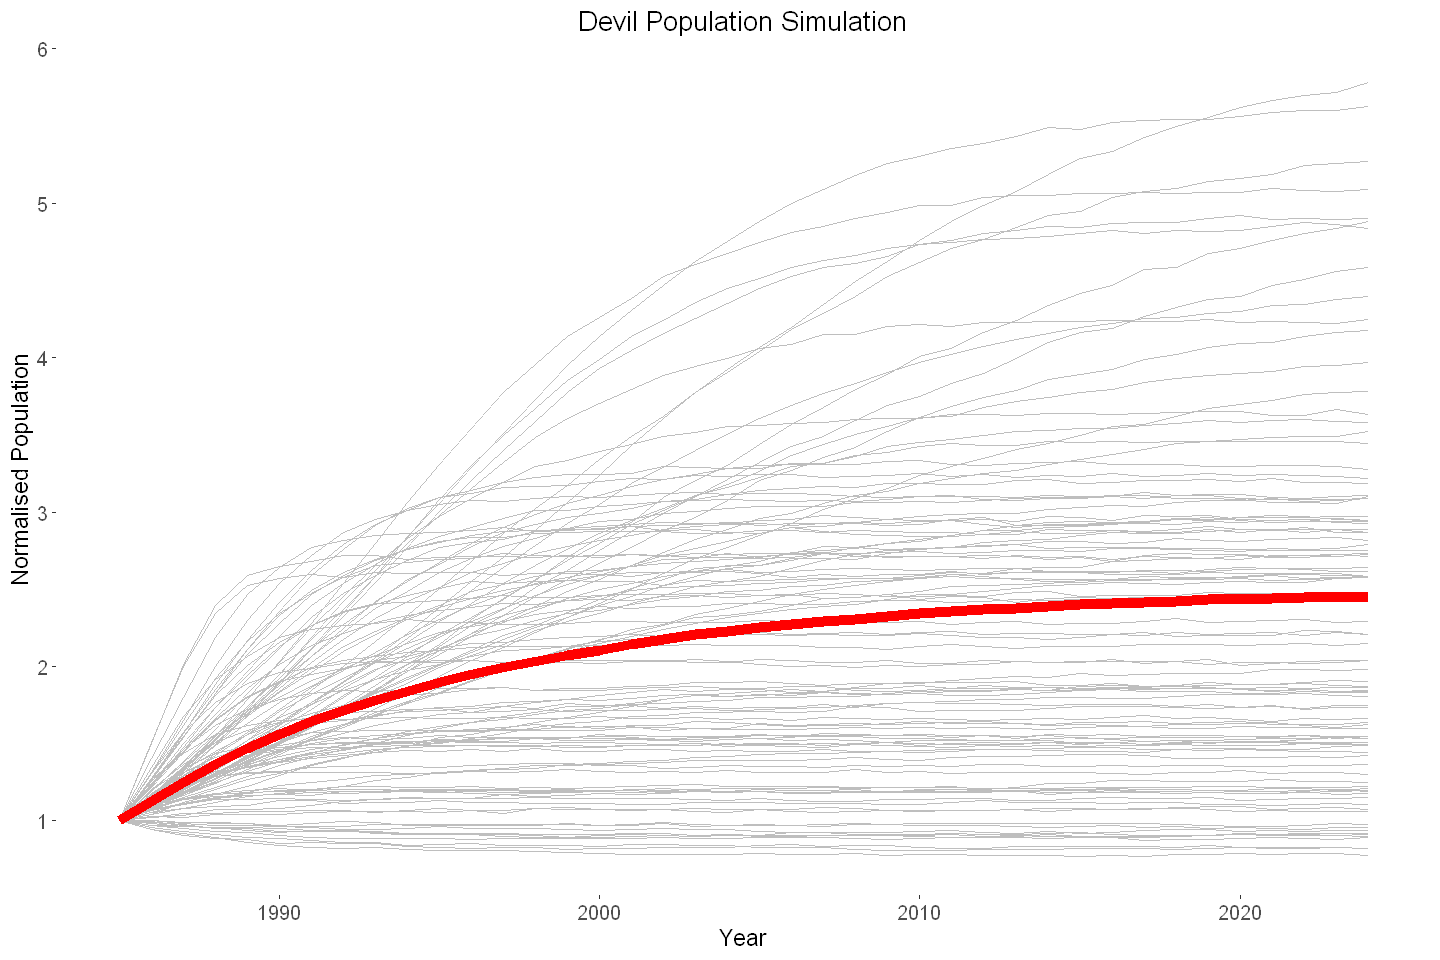

In [76]:
ggplot(selected_total_long, aes(x = variable, y = value, group = id, color = line_color, size = line_size)) +
  geom_line() +
  labs(title = "Devil Population Simulation",
       x = "Year",
       y = "Normalised Population") +
  scale_color_identity() +  # Use the color as it is
  scale_size_identity() +  # Use the size as it is
  theme(
    axis.title.x = element_text(size = 14),  # X-axis label font size
    axis.title.y = element_text(size = 14),  # Y-axis label font size
    axis.text.x = element_text(size = 12),   # X-axis tick labels font size
    axis.text.y = element_text(size = 12),   # Y-axis tick labels font size
    plot.title = element_text(size = 16, hjust = 0.5),  # Plot title font size  
    panel.background = element_blank(),  # Remove the background
    panel.grid.major = element_blank(),  # Remove major grid lines
    panel.grid.minor = element_blank(),  # Remove minor grid lines
    plot.background = element_blank()  # Remove the plot background (if desired)
  )

### population map

In [51]:
mat_list <- list()
for (year in 1:simulation_years){
    abund=colSums(selected_mat[,((year-1)*length(landarea)+1):(year*length(landarea))]*replicate(length(landarea), weights$weight))
    mat_list=append(mat_list, list(abund))
}
    

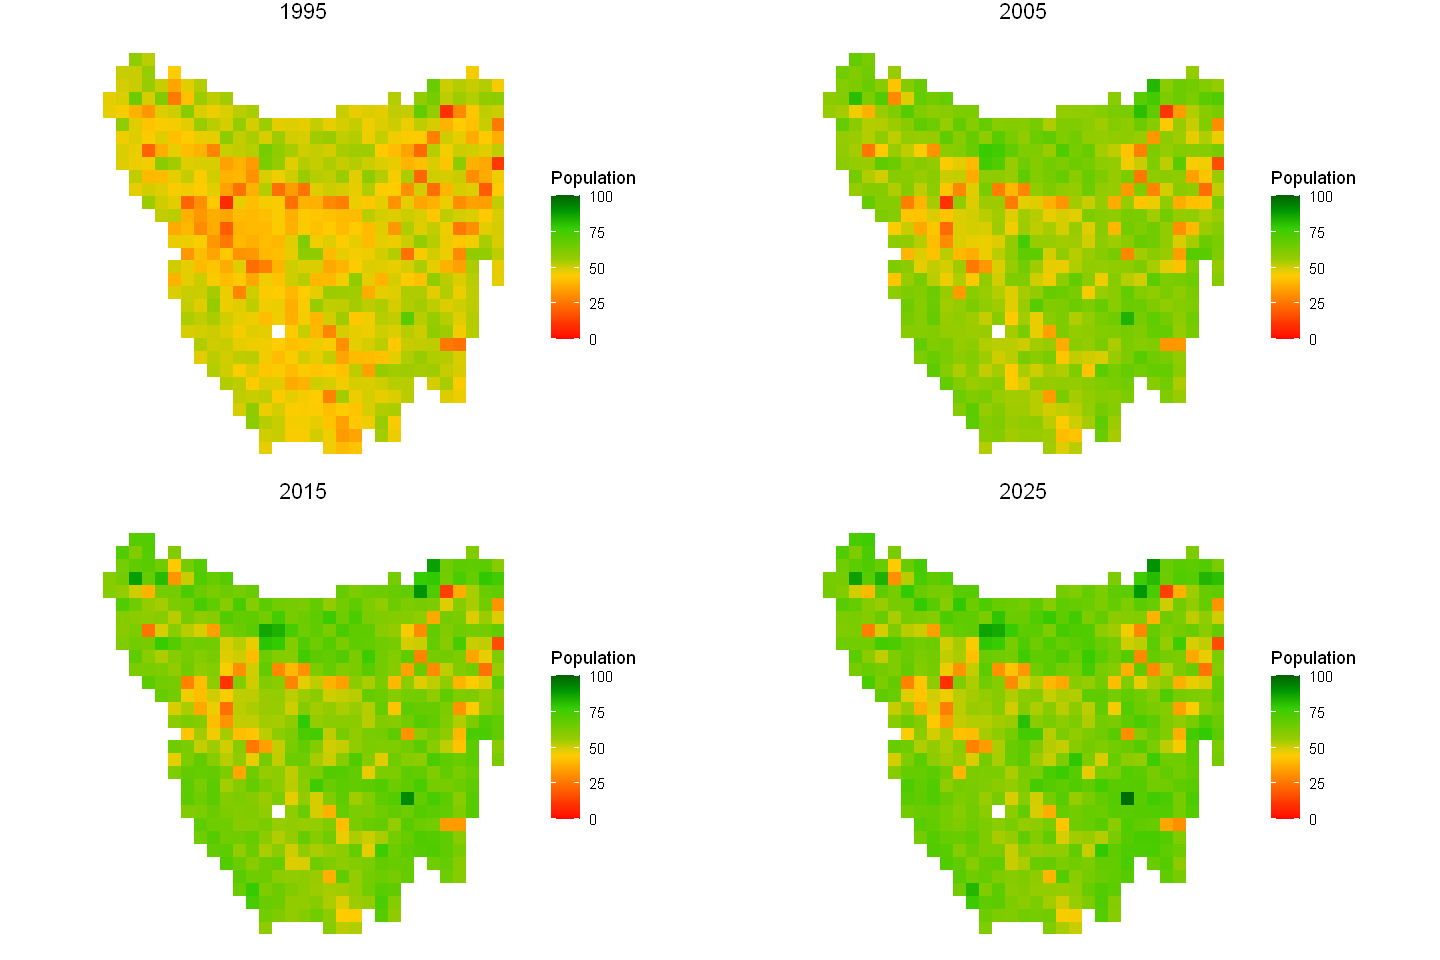

In [104]:
# Convert raster to ggplot
raster_to_ggplot <- function(raster_data, title) {
  # Convert raster to points (coordinates + values) using raster::rasterToPoints
  df <- as.data.frame(raster::rasterToPoints(raster_data))
  colnames(df) <- c("Longitude", "Latitude", "Value")
  
  # Create ggplot object
  p <- ggplot(df, aes(x = Longitude, y = Latitude, fill = Value)) +
    geom_raster() +
    scale_fill_gradientn(colors = c("#FF0000", "#FF3300", "#FF6600", "#FF9900", "#FFCC00", 
             "#99CC00", "#66CC00", "#33CC00", "#009900", "#006400"),
                        limits = c(0, 100),name='Population') +  # Add color legend with name
    theme_minimal() +
    labs(title = title) +
    theme(
#       legend.position = "none",  # Remove the legend completely
        aspect.ratio = 1,  # Force a 1:1 aspect ratio
      axis.title = element_blank(),  # Remove axis titles
      axis.text = element_blank(),  # Remove axis labels
      axis.ticks = element_blank(),  # Remove axis ticks
      panel.grid.major = element_blank(),  # Remove major gridlines
      panel.grid.minor = element_blank(),  # Remove minor gridlines
      plot.margin = margin(1, 1, 1, 1),  # Optional: Add margin around plot for spacing
      plot.title = element_text(hjust = 0.5)  # Center the plot title
    )+
    coord_fixed(ratio = 1)  # Ensure the plot has a square aspect ratio
  
  return(p)
}

# Plot for 1995
example_hs_raster1 <- region$region_raster
example_hs_raster1[region$region_indices] <- mat_list[[10]]
p1 <- raster_to_ggplot(example_hs_raster1, "1995")

# Plot for 2005
example_hs_raster2 <- region$region_raster
example_hs_raster2[region$region_indices] <- mat_list[[20]]
p2 <- raster_to_ggplot(example_hs_raster2, "2005")

# Plot for 2015
example_hs_raster3 <- region$region_raster
example_hs_raster3[region$region_indices] <- mat_list[[30]]
p3 <- raster_to_ggplot(example_hs_raster3, "2015")

# Plot for 2025
example_hs_raster4 <- region$region_raster
example_hs_raster4[region$region_indices] <- mat_list[[40]]
p4 <- raster_to_ggplot(example_hs_raster4, "2025")

# Arrange the plots in a 2x2 grid
grid.arrange(p1, p2, p3, p4, ncol = 2, nrow = 2)

In [91]:
min(14332/sum(example_hs)*example_hs)

[1] 4.187355

In [92]:
max(14332/sum(example_hs)*example_hs)

[1] 41.87355

In [108]:
max(mat_list[[40]])*2/100

[1] 1.955421

In [93]:
min(mat_list[[40]])

[1] 9.582198

In [95]:
min(example_hs*114)

[1] 11.4

In [80]:
sum(example_hs*114)*2/650/100

[1] 1.200573

In [112]:
114*2/100

[1] 2.28

In [102]:
sum(example_hs*114)

[1] 39018.62

In [116]:
sum(mat_list[[11]])*2/650/100

[1] 0.9554258

In [117]:
sum(mat_list[[11]])*2

[1] 62102.68

In [78]:
max(mat_list[[11]])*2/100

[1] 1.458551